## FAVORITA STORES SALE

### HYPOTHESIS
Null Hypothesis: Promotions do not affect sales

Alternative hypothesis: Promotions increases sales

## Data Preparation

### Questions

The questions below are to be answered. Do note that, you are free to draw more hypothesis from the data.

1) Is the train dataset complete (has all the required dates)?

2) Which dates have the lowest and highest sales for each year?

3) Did the earthquake impact sales?

4) Are certain groups of stores selling more products? (Cluster, city, state, type)

5) Are sales affected by promotions, oil prices and holidays?

6) What analysis can we get from the date and its extractable features?

7) What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

In [163]:
# Import the necessary libraries

import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

In [164]:
# Load environment variables from .env file into a dictionary
db_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = db_variables.get("SERVER")
database = db_variables.get("DATABASE")
username = db_variables.get("USER")
password = db_variables.get("PASSWORD")

connection = f"DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [165]:
# Connect to the tables in the db

conn = pyodbc.connect(connection)

query = "SELECT * FROM dbo.oil"
query1 = "SELECT * FROM dbo.holidays_events"
query2 = "SELECT * FROM dbo.stores"

### 1st Dataset

In [166]:
# dbo.oil

oil = pd.read_sql(query,conn)
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [167]:
# dbo.holidays_events

holidays_events = pd.read_sql(query1,conn)
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [168]:
# dbo.stores

stores = pd.read_sql(query2,conn)
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [169]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [170]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [171]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [172]:
# To change the date to the correct datatype

oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

### TEST dataset

In [173]:
# sample_submission

df_sample = pd.read_csv('sample_submission.csv')
df_sample.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [174]:
test = pd.read_csv('test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [175]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [176]:
test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

### 3rd Dataset

In [177]:
df_trx = pd.read_csv("transactions.csv")
df_trx.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [178]:
df_train = pd.read_csv("E:\\AZUBI CAREER ACCELERATOR\\Data Analytics\\PROJECTS\\Project 3\\LP3 Regression Project\\store-sales-forecasting\\train.csv")
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [179]:
df_trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [180]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [181]:
# To change the date to correct datatype

df_trx['date'] = pd.to_datetime(df_trx['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

# Data Understanding

## To check for missing data

In [182]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [183]:
holidays_events.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [184]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [185]:
df_trx.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [186]:
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

- Only the oil dataset has 43 missing values on the 'dicoilwtico' column 
##### Fill missing values in the 'dcoilwtico' (daily crude oil prices) column using backfill strategy

In [187]:
# Fill missing values in the 'dcoilwtico' column using backfill strategy
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='backfill')

#### Confirm the missing values handled

In [188]:
oil.isna().sum()

date          0
dcoilwtico    0
dtype: int64

### Merging the Datasets

In [189]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_data with stores_df based on 'store_nbr' column
merged_df1 = pd.merge(df_train,stores, on='store_nbr', how='inner')
 
# Merge merged_df1 with trans_data based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(df_trx, on=['date', 'store_nbr'], how='inner')
 
# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(holidays_events, on='date', how='inner')
 
# Merge merged_df3 with oil_df based on 'date' column
data= merged_df3.merge(oil, on='date', how='inner')
 
# View the first five rows of the merged dataset
data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


We have used an inner merge to combine the datasets to ensures that we are working with a unified dataset that contains only the relevant information for the dates common to all datasets, facilitating a cleaner and more consistent analysis for time series forecasting.helps in avoiding having rows with missing values or mismatched timestamps in the final dataset.

Also an inner merge ensures that all the data points in the resulting dataset share the same timestamps, providing a unified time index for analysis and modeling.

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   type_x        322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  type_y        322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

- It is seen that we have no null values in the merged data.
- The merged dataset consists of 322,047 non-null observations.
- Two columns have been renamed as a result of the merging, type_x and type_y.

In [191]:
# Renaming the columns with the approapriate names
data = data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,73062,2013-02-11,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
1,73063,2013-02-11,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
2,73064,2013-02-11,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
3,73065,2013-02-11,1,BEVERAGES,172.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002
4,73066,2013-02-11,1,BOOKS,0.0,0,Quito,Pichincha,D,13,396,Holiday,National,Ecuador,Carnaval,False,97.010002


In [192]:
# Generate summary statistics 
data.describe().T

,count,mean,min,25%,50%,75%,max,std
id,322047.0,1682979.459576,561.0,1010616.5,1842406.0,2209555.5,3000887.0,786249.257767
date,322047,2015-08-04 23:49:57.971103488,2013-01-01 00:00:00,2014-07-23 00:00:00,2015-11-02 00:00:00,2016-05-27 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,322047.0,26.994672,1.0,13.0,27.0,40.0,54.0,15.595174
sales,322047.0,406.383452,0.0,1.0,19.0,241.260505,124717.0,1246.88124
onpromotion,322047.0,3.727136,0.0,0.0,0.0,1.0,716.0,15.512095
cluster,322047.0,8.531202,1.0,4.0,9.0,13.0,17.0,4.713809
transactions,322047.0,1734.11784,54.0,1030.0,1409.0,2148.0,8359.0,1050.335018
dcoilwtico,322047.0,63.636381,27.959999,44.880001,51.98,94.089996,107.949997,24.855753


In [193]:
duplicates=data.duplicated().sum()
duplicates

0

In [194]:
# To check for missing values in merged dataset
data.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

### Save data to CSV for later use in Visualization

In [197]:
data.to_csv('V_Data.csv', index=False)


# EDA

### Univariate analysis

<Figure size 400x400 with 0 Axes>

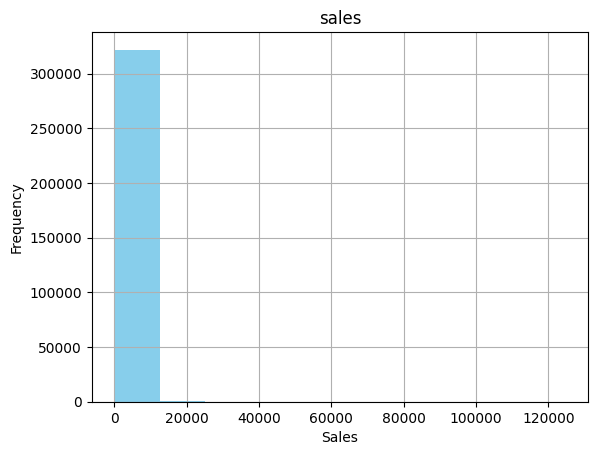

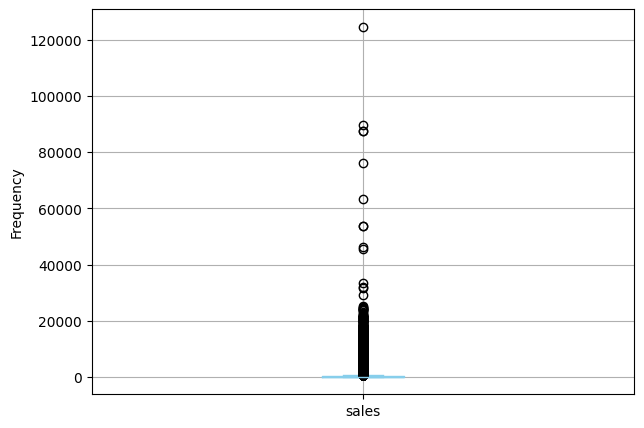

In [210]:
# To check for any outliers in the data

plt.figure(figsize=(4,4))
data.hist(column=['sales'],color='skyblue')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='sales',color='skyblue')
plt.ylabel('Frequency')
plt.show()

* From the graphs above it shows that the sales data does not have any skiewness and that its has outliers

<Figure size 400x400 with 0 Axes>

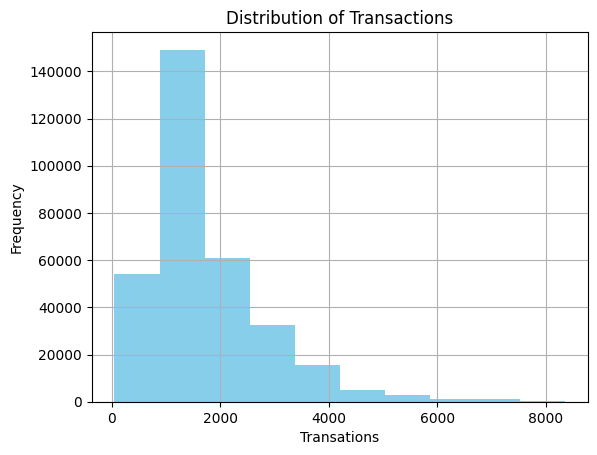

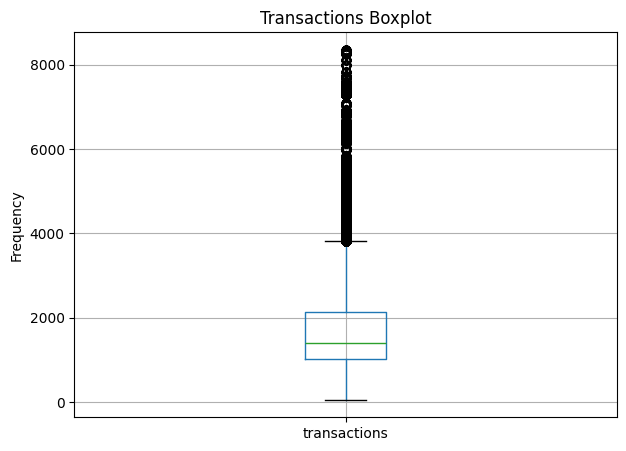

In [217]:
# Transaction data

plt.figure(figsize=(4,4))
data.hist(column=['transactions'],color='skyblue')
plt.xlabel('Transations')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='transactions')
plt.ylabel('Frequency')
plt.title('Transactions Boxplot')
plt.show()

The histogram provides insights into the distribution of transactions in the dataset. The shape of the histogram indicates that the majority of transactions fall into a specific range, which is evident from the high frequency observed on the left side of the histogram. As the transactions increase, the frequency gradually decreases, forming a right-skewed distribution. This suggests that there are relatively fewer instances of high transaction volumes. Overall, the histogram highlights the presence of a cluster of transactions with a lower frequency, indicating a pattern in the data.

<Figure size 400x400 with 0 Axes>

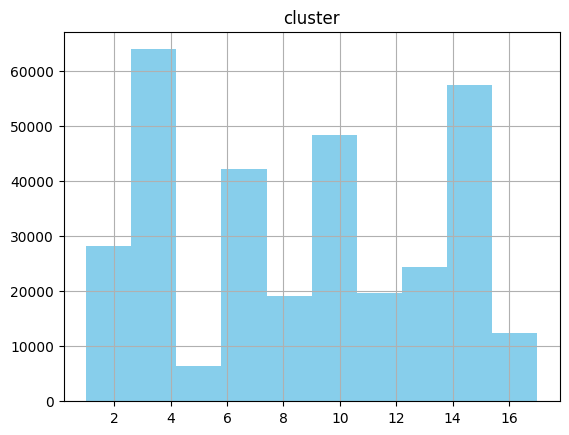

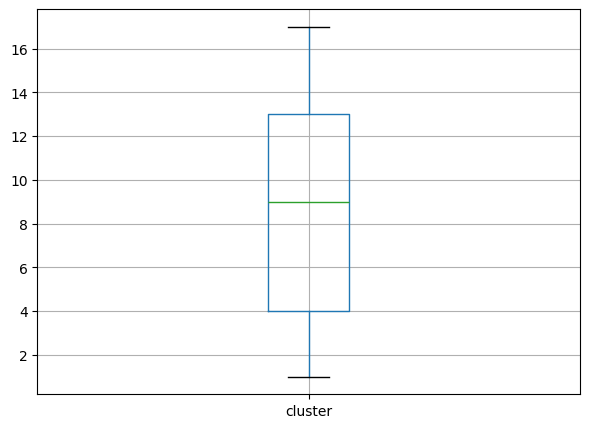

In [216]:
plt.figure(figsize=(4,4))
data.hist(column=['cluster'],color='skyblue')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='cluster')
plt.show()

<Figure size 400x400 with 0 Axes>

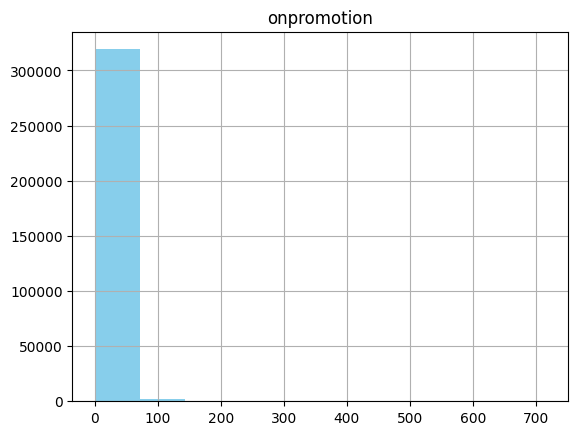

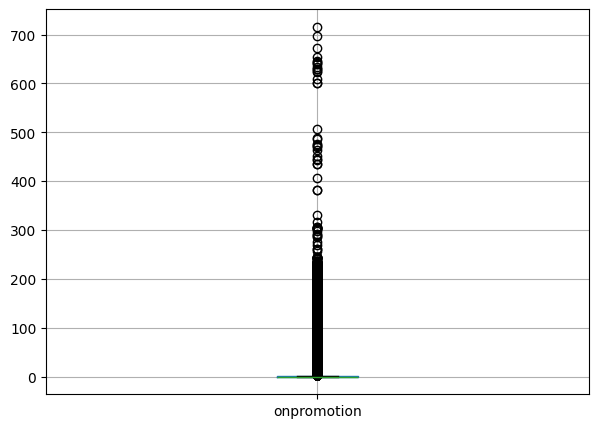

In [215]:
plt.figure(figsize=(4,4))
data.hist(column=['onpromotion'],color='skyblue')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='onpromotion')
plt.show()

* The onpromotion data indicates no skeweness but the boxplot shows that it has outliers

<Figure size 400x400 with 0 Axes>

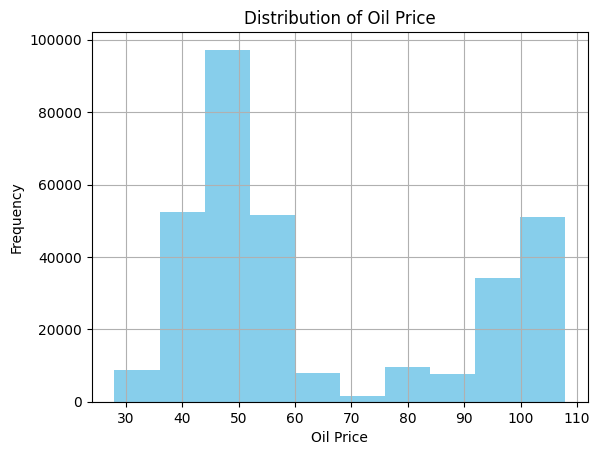

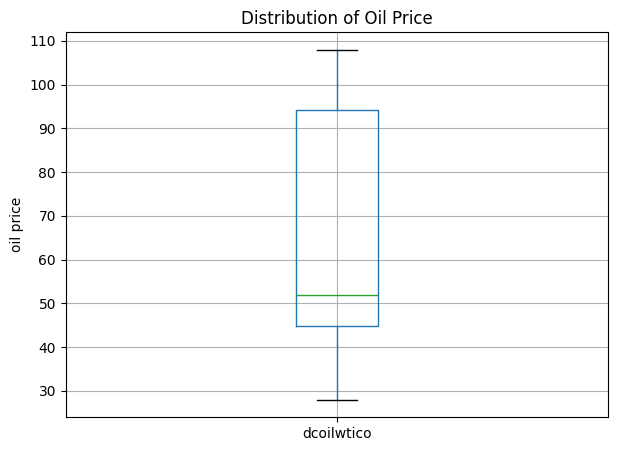

In [214]:
# Distribution of oil prices

plt.figure(figsize=(4,4))
data.hist(column=['dcoilwtico'],color='skyblue')
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='dcoilwtico')
plt.ylabel('oil price')
plt.title('Distribution of Oil Price')
plt.show()

The histogram and boxplot of the 'dcoilwtico' variable reveal insights into its distribution. The histogram displays the frequency distribution of oil prices, indicating the number of occurrences for each price range.
The prices are not evenly distributed across a range ,there are clusters/peaks, indicating specific price levels that occur more frequently.

### Bivariate

#### Trend of Sales over time

In [218]:
# Group the data by date and calculate the total sales
daily_sales = data.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

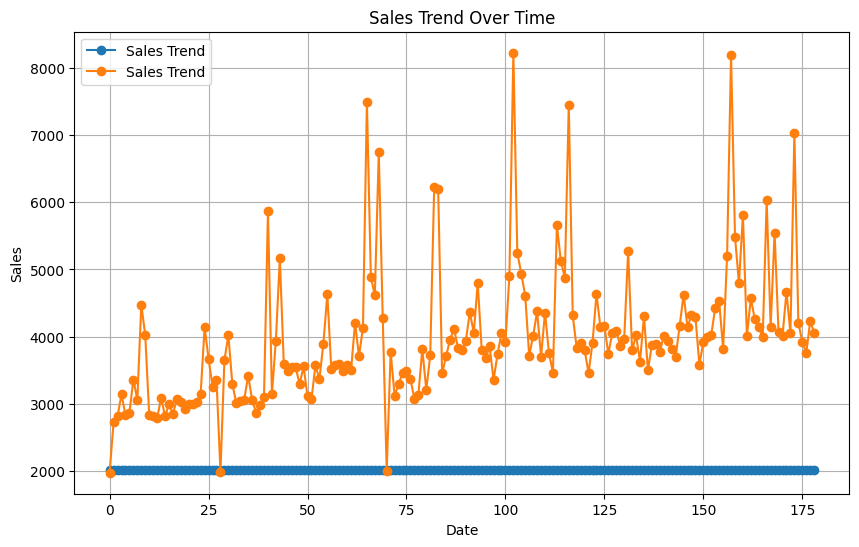

In [219]:
daily_sales = data.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(daily_sales, label='Sales Trend', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Over Time')
plt.grid(True)
plt.legend()
plt.show()

The plot shows the trend of sales over time. From the graph, we can observe that the sales exhibit some variations and fluctuations over time. There are periods of both high and low sales, indicating potential seasonality or other factors affecting sales patterns.

### Trend of Crude oil Prices

In [221]:
# Visualizing the 'dcoilwtico' column to confirm if the trend is consistent.
fig = px.line(oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.show()

We can see that oil prices suffered a collapse towards the end of 2014 and have not recovered. In fact despite some volatility, oil prices are at the same level as they were in the beginning of 2015. As a result of this we may see a significant shift in store sales around late 2014. Looking at the unit sales data, this is not readily apparent. Although sales do appear to drop off in the early part of 2015, in late 2014 they are rising. Also, to add oil price drop doesn't seems to have any impact on the sales, as it was seen from the sales plot, there was no relation between oil price dropping on the sales, so we can say that this feature or data is of no importance to us and will not be considered during modelling.

### Multivariate

In [ ]:
num_data = ['sales','transactions','onpromotion','dcoilwtico']
corr = data.corr(numeric_only=True)
corr

,id,store_nbr,sales,onpromotion,cluster,transactions,transferred,dcoilwtico
id,1.000000,0.013728,0.061237,0.181707,-0.018880,-0.018267,0.133468,-0.836786
store_nbr,0.013728,1.000000,0.051349,0.025992,-0.075667,0.171946,0.001440,-0.010286
sales,0.061237,0.051349,1.000000,0.418029,0.033868,0.203691,-0.007167,-0.062568
onpromotion,0.181707,0.025992,0.418029,1.000000,0.005895,0.038163,0.028325,-0.133799
cluster,-0.018880,-0.075667,0.033868,0.005895,1.000000,0.188876,-0.001880,0.021655
transactions,-0.018267,0.171946,0.203691,0.038163,0.188876,1.000000,-0.043902,-0.017944
transferred,0.133468,0.001440,-0.007167,0.028325,-0.001880,-0.043902,1.000000,-0.052458
dcoilwtico,-0.836786,-0.010286,-0.062568,-0.133799,0.021655,-0.017944,-0.052458,1.000000


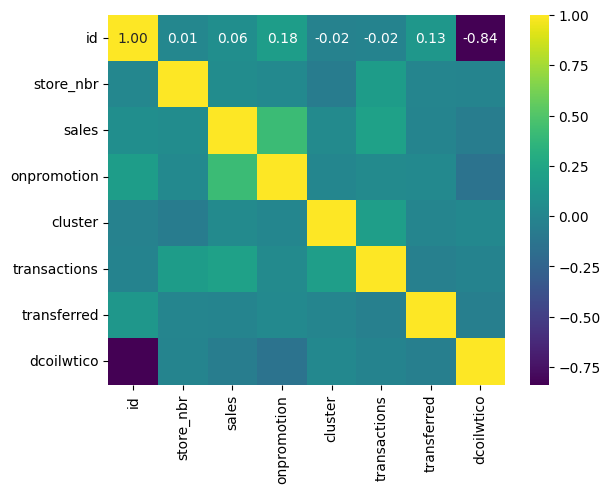

In [ ]:
heatmap = sns.heatmap(data=corr,annot=True, cmap='viridis',fmt=".2f",xticklabels=True,yticklabels=True)

plt.show()



- Sales and Transactions:

There is a weak positive correlation of approximately 0.200 between "Sales" and "Transactions." This suggests that there is a slight positive relationship between the number of transactions and the sales. It implies that when the number of transactions increases, there is a tendency for sales to increase as well, although the correlation is not very strong.

- Sales and Dcoilwito (Oil Prices):

There is a weak negative correlation of approximately -0.062 between "Sales" and "Dcoilwito" (Oil Prices). This indicates a slight negative relationship between sales and oil prices. It suggests that as oil prices increase, there is a tendency for sales to decrease slightly, though the correlation is not significant.

- Transactions and Dcoilwito (Oil Prices):

There is a very weak negative correlation of approximately -0.017 between "Transactions" and "Dcoilwito" (Oil Prices). This suggests that there is almost no relationship between the number of transactions and oil prices. It indicates that fluctuations in oil prices do not have a significant impact on the number of transactions.

### 1)Is the train dataset complete (has all the required dates)?

In [ ]:
data['date'] = pd.to_datetime(data['date'])
min_date = data['date'].min()
max_date = data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)
 
missing_dates = expected_dates[~expected_dates.isin(data['date'])]
 
if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

In [ ]:
test['date'] = pd.to_datetime(test['date'])
min_date = test['date'].min()
max_date = test['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)
 
missing_dates = expected_dates[~expected_dates.isin(data['date'])]
 
if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

### 2) Which dates have the lowest and highest sales for each year?

In [ ]:
#Extract the year from the 'date' column
# data['year'] = data['date'].dt.year



# #Group by year and find the dates with the lowest and highest sales
# data = data.dropna(subset=['year'])

# # Group by year and find the dates with the lowest and highest sales
# min_dates = data.loc[data.groupby('date')['sales'].idxmin(), ['year', 'date', 'sales']]
# max_dates = data.loc[data.groupby('date')['sales'].idxmax(), ['year', 'date', 'sales']]

# # Display the results
# print("Dates with the Lowest Sales for Each Year:")
# print(min_dates)

# print("\nDates with the Highest Sales for Each Year:")
# print(max_dates)

### 3) Did the earthquake impact sales?

In [ ]:
sales_2016 = data[data['year'] == 2016]

# Extract months for the year 2016
sales_2016_months = data_2016['month']

# Display the results
sales_2016_months

In [ ]:
plt.figure(figsize=(8,6))

sns.lineplot(x=sales_2016_months.values, y=sales_2016_months.index,color='orange')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales per Year')
plt.show()

### 4) Are certain groups of stores selling more products? (Cluster, city, state, type)

In [ ]:
result = (
    data.groupby(['city','type'])['sales']
    .count()
    .sort_values(ascending=False)
    .head()
    
)

print(result)


In [ ]:
plt.figure(figsize=(8,6))
result.plot(kind='bar', color='pink')
plt.xlabel('store_number')
plt.ylabel('Sales')
plt.title('Total sales based on Store number')
plt.show();


### 5) Are sales affected by promotions, oil prices and holidays?

In [ ]:
#data['Year'] = data['date'].dt.year

data.head(3)

In [ ]:
data['type'].unique()

In [ ]:

# Assuming 'type', 'onpromotion', and 'sales' are columns in your DataFrame
variables = data[(data['type'] == 'Holiday') & (data['onpromotion'] >= 1)]

# Group by the conditions and calculate the sum of 'sales' for each group
result = groupby(variables)['sales'].sum()

# Display the results
print(result)


# Display the results


In [ ]:
T_promos = (
    data.groupby(['onpromotions'])['sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .reset_index()  # Reset index to make it a DataFrame
)



T_promos.plot(kind='bar', color='skyblue')




6) What analysis can we get from the date and its extractable features?


In [ ]:
df = data.groupby('date')['sales'].sum()
df

In [ ]:

# Create a time series plot
fig = px.line(data_frame=date, x='date', y='sales', title='Time Series Plot with Time Adjustments')

# Show the plot
fig.show()
